### This notebook showcases how to use **Google Earth Engine (GEE)** and  **Sentinel-2** data to analyze wildfire events based on **MODIS/VIIRS** fire data. We will load fire event data, extract relevant imagery, visualize the affected area, and download satellite images.

This command clones the GitHub repository containing the wildfire detection code and dataset into the Colab environment.

In [1]:
!git clone https://github.com/gunelaliyevaa/wildfire-detection-using-satellite-imagery.git

Cloning into 'wildfire-detection-using-satellite-imagery'...
remote: Enumerating objects: 956, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 956 (delta 106), reused 81 (delta 32), pack-reused 741 (from 2)
Receiving objects: 100% (956/956), 201.65 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Updating files: 100% (688/688), done.


Moves into the cloned project directory, allowing access to scripts and data files.

In [2]:
%cd wildfire-detection-using-satellite-imagery

/content/wildfire-detection-using-satellite-imagery


In [3]:
!git pull

Already up to date.


Installs the custom dataset processing library (dataset_processing_lib) that contains utility functions for data handling, GEE authentication, and image processing.

In [4]:
!pip install ./dataset_processing_lib

Processing ./dataset_processing_lib
  Preparing metadata (setup.py) ... done
  Created wheel for dataset_processing_lib: filename=dataset_processing_lib-0.1-py3-none-any.whl size=1049 sha256=9f495488e78d2784670f028056cc08c1597a98fa87966d5a886a37819f6bdfe9
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8jja3qm/wheels/d9/15/c5/454d05cf2f9f5352b6b032a3962b5a9f4793b02841e7e4585c
Successfully built dataset_processing_lib


 Imports the custom library as dpl, making all functions accessible.

In [5]:
import dataset_processing_lib as dpl

 Authenticates Google Earth Engine (GEE) for cloud-based satellite image processing.

In [6]:
dpl.auth_earth_engine(project_id="wildfire-detection-ml")

 Loads wildfire event data from a CSV file. The dataset contains fire locations, detection times, and other parameters.

In [57]:
fire_data = dpl.load_fire_data("/content/wildfire-detection-using-satellite-imagery/data/raw/modis/2023_fire_archive_M-C61_539023.csv")
fire_data

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,40.0181,46.0989,305.3,1.8,1.3,2023-01-01,707,Terra,MODIS,58,61.03,273.3,24.7,D,0
1,40.0199,46.0781,307.1,1.8,1.3,2023-01-01,707,Terra,MODIS,65,61.03,272.7,28.1,D,0
2,40.0198,46.0844,303.3,1.0,1.0,2023-01-01,1009,Aqua,MODIS,33,61.03,281.6,7.6,D,0
3,40.0281,46.2014,304.9,1.0,1.0,2023-01-01,1009,Aqua,MODIS,60,61.03,282.2,9.1,D,0
4,40.0109,46.0866,308.8,1.0,1.0,2023-01-01,1009,Aqua,MODIS,57,61.03,283.7,11.3,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,39.5438,48.1411,302.6,2.1,1.4,2023-12-26,1049,Aqua,MODIS,53,61.03,288.1,14.9,D,0
711,39.2368,48.6723,303.1,2.2,1.4,2023-12-26,1049,Aqua,MODIS,55,61.03,288.9,18.6,D,0
712,40.6039,47.5977,302.2,1.2,1.1,2023-12-28,1034,Aqua,MODIS,51,61.03,283.4,9.0,D,2
713,40.0981,47.3465,304.3,1.2,1.1,2023-12-28,1034,Aqua,MODIS,58,61.03,286.7,8.4,D,0


Extracts latitude, longitude, and acquisition date of a specific fire event (7th row).

Defines a time window (start_date = acq_date - 1 day, end_date = acq_date + 1 day) for Sentinel-2 imagery.

In [88]:
import pandas as pd

latitude, longitude = fire_data.iloc[6]['latitude'], fire_data.iloc[6]['longitude']
acq_date = pd.to_datetime(fire_data.iloc[6]['acq_date'])

start_date = (acq_date - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
end_date = (acq_date + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

print(f"Using Latitude: {latitude}, Longitude: {longitude}")
print(f"Start Date: {start_date}, End Date: {end_date}")

Using Latitude: 40.0083, Longitude: 46.0811
Start Date: 2023-01-01, End Date: 2023-01-03


Generates a bounding box (rectangle) around the fire event location, which is used for filtering satellite imagery.

In [89]:
rectangle = dpl.create_rectangle(longitude, latitude)
rectangle

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              46.061099999999996,
              40.0283
            ],
            [
              46.061099999999996,
              39.988299999999995
            ],
            [
              46.1011,
              39.988299999999995
            ],
            [
              46.1011,
              40.0283
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

Displays an interactive map with the fire event location and its bounding box using folium and geemap.

In [90]:
import folium
import geemap

# Initialize a folium map centered at the fire event location
alert_area = geemap.Map(center=[latitude, longitude], zoom=13)

# Convert EE geometry to GeoJSON and add it to the map
alert_area.addLayer(rectangle, {"color": "red"}, "Fire Event Area")

# Display the map
alert_area


Map(center=[40.0083, 46.0811], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

 Retrieves Sentinel-2 images for the selected fire event location within the defined time range.
Counts the number of available images.



In [91]:
collection, rectangle = dpl.fetch_image_collection(longitude, latitude, start_date, end_date)

print("Number of images in collection:", collection.size().getInfo())

Number of images in collection: 1


Processes the Sentinel-2 images by selecting RGB bands (B4, B3, B2 → Red, Green, Blue).
Generates a download URL for visualization.

In [92]:
from IPython.display import display

processed_image = dpl.process_image(collection, rectangle)

if processed_image:
    url = dpl.generate_download_url(processed_image, rectangle)
    print("Generated Image URL:", url)
else:
    print("No suitable image found.")


Generated Image URL: https://earthengine.googleapis.com/v1/projects/wildfire-detection-ml/thumbnails/3bc4a8ea1b005d1fa8522fcfb4db71ed-cd23e0d1581276d9700c2b76d168dcb7:getPixels


Downloads the processed Sentinel-2 image to a local folder (/content/images).
Displays the downloaded image directly in the notebook.



Downloaded: /content/images/40.0083_46.0811.png


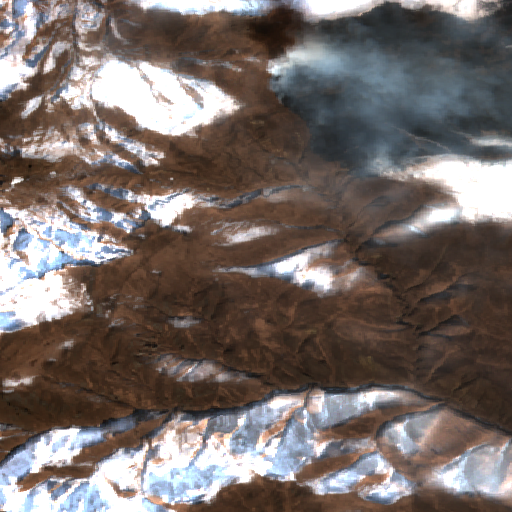

In [93]:
import os
output_dir = "/content/images"
os.makedirs(output_dir, exist_ok=True)

if processed_image:
    filename = f"{latitude}_{longitude}.png"
    dpl.download_image(url, output_dir, filename)

    # Display the downloaded image
    from IPython.display import Image
    display(Image(os.path.join(output_dir, filename)))
